### Importando as bibliotecas necessárias

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#### TensorFlow requer a versão Python 3.12.7
As versões mais atuais até a data de criação desde arquivo (19/04/2025) a versão Python 3.13.2 não possuem suporte ao TensorFlow.

In [19]:
# Verifica se o TensorFlow está instalado corretamente e se a GPU está disponível
print(tf.__version__)
print("GPU disponível:", tf.config.list_physical_devices('GPU'))

2.19.0
GPU disponível: []


### 1. Preparação dos Dados

In [20]:
# Carregar os dados
df = pd.read_csv('d:/GitHub Respositorios/microsoft-certification-challenge_DP100/database/amazonfish.csv')

# Converter a coluna de data para datetime e extrair features temporais
df['Data'] = pd.to_datetime(df['Data'])
df['Dia'] = df['Data'].dt.day
df['DiaDaSemana'] = df['Data'].dt.dayofweek
df['FimDeSemana'] = df['DiaDaSemana'].apply(lambda x: 1 if x >= 5 else 0)

# Calcular a variável target: Vendas Totais (Preço Unitário * Quantidade Vendida)
df['Vendas_Totais'] = df['Preço Unitário'] * df['Quantidade Vendida']

# Separar features e target
X = df.drop(['Vendas_Totais', 'Data'], axis=1)
y = df['Vendas_Totais']

# Definir colunas categóricas e numéricas
cat_cols = ['Produto', 'Categoria', 'Condição Climática', 'Evento de Pesca', 'Região de Venda']
num_cols = ['Preço Unitário', 'Quantidade Vendida', 'Temperatura (°C)', 'Tempo de Navegação', 'Dia', 'DiaDaSemana', 'FimDeSemana']

# Criar transformadores para pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré-processar os dados
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### 2. Modelo Randon Forest

In [21]:
# Criar e treinar o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)

# Fazer previsões
y_pred_rf = rf_model.predict(X_test_processed)

# Avaliar o modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")

Random Forest - MSE: 183514.81, R²: 0.68


### 3. Modelo LSTM (para dados temporais)

In [22]:
# Preparar dados para LSTM (considerando a sequência temporal)
df_lstm = df.sort_values('Data').set_index('Data')

# Criar sequências temporais
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 7  # usar 7 dias para prever o próximo
X_lstm, y_lstm = create_sequences(df_lstm['Vendas_Totais'].values, n_steps)

# Dividir em treino e teste
train_size = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Redimensionar para LSTM [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Criar modelo LSTM
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=100, verbose=0)

# Fazer previsões
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Avaliar o modelo
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)

print(f"LSTM - MSE: {mse_lstm:.2f}, R²: {r2_lstm:.2f}")

c:\Users\junio\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
LSTM - MSE: 1346436.62, R²: -0.35


### 4. Modelo de Regressão Linear

In [23]:
# Criar e treinar o modelo de Regressão Linear
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)

# Fazer previsões
y_pred_lr = lr_model.predict(X_test_processed)

# Avaliar o modelo
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Regressão Linear - MSE: {mse_lr:.2f}, R²: {r2_lr:.2f}")

Regressão Linear - MSE: 844467.45, R²: -0.46


### 5. Comparação dos Modelos


Comparação dos Modelos:
             Modelo           MSE        R²
0     Random Forest  1.835148e+05  0.682409
1              LSTM  1.346437e+06 -0.346425
2  Regressão Linear  8.444675e+05 -0.461435


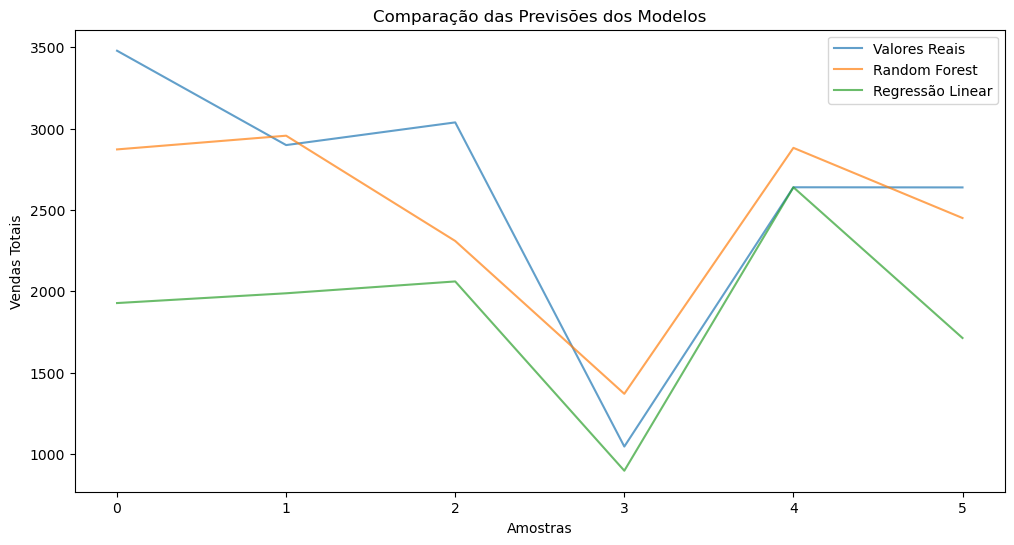

In [24]:
# Comparar os modelos
results = pd.DataFrame({
    'Modelo': ['Random Forest', 'LSTM', 'Regressão Linear'],
    'MSE': [mse_rf, mse_lstm, mse_lr],
    'R²': [r2_rf, r2_lstm, r2_lr]
})

print("\nComparação dos Modelos:")
print(results)

# Visualizar previsões vs valores reais
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores Reais', alpha=0.7)
plt.plot(y_pred_rf, label='Random Forest', alpha=0.7)
plt.plot(y_pred_lr, label='Regressão Linear', alpha=0.7)
plt.title('Comparação das Previsões dos Modelos')
plt.xlabel('Amostras')
plt.ylabel('Vendas Totais')
plt.legend()
plt.show()

### 6. Análise da importância das variáveis (Random Forest)

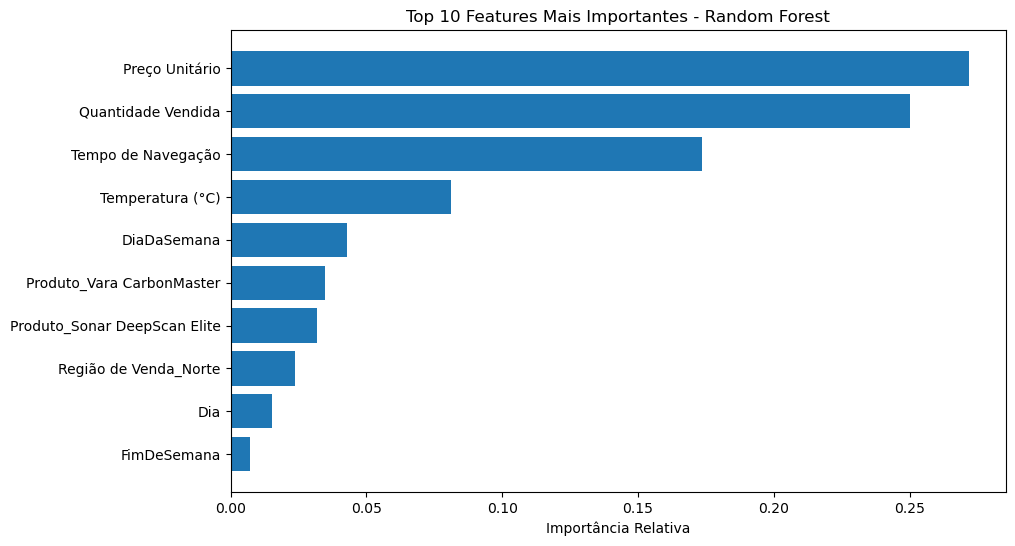

In [25]:
# Obter nomes das features após one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, cat_feature_names])

# Obter importâncias das features
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features

# Plotar importância das features
plt.figure(figsize=(10, 6))
plt.title('Top 10 Features Mais Importantes - Random Forest')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
plt.xlabel('Importância Relativa')
plt.show()